# Imports

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

# Deep Learning Imports


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Load Dataset


In [55]:
df = pd.read_csv("hr_analysis_data.csv")
print("Dataset Shape:", df.shape)


Dataset Shape: (54808, 14)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [ ]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


#Check and Fill Missing


In [56]:
df['previous_year_rating'].fillna(df['previous_year_rating'].median(), inplace=True)

<ipython-input-56-e6bd09b750da>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['previous_year_rating'].fillna(df['previous_year_rating'].median(), inplace=True)


#Label Encoding

In [57]:
df['previous_year_rating'].fillna(df['previous_year_rating'].median(), inplace=True)

label_cols = ['department', 'education', 'gender']
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col])


<ipython-input-57-b0f12e7cc94f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['previous_year_rating'].fillna(df['previous_year_rating'].median(), inplace=True)


# Feature Engineering: Create Synthetic Target

In [58]:
df['is_promoted'] = ((df['awards_won?'] == 1) &
                     (df['KPIs_met >80%'] == 1) &
                     (df['previous_year_rating'] >= 4)).astype(int)

# Add Tenure Group


In [60]:
df['tenure_group'] = pd.cut(df['length_of_service'],
                            bins=[0, 2, 5, 10, 20],
                            labels=['0-2', '3-5', '6-10', '10+'])
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

# Features and Target


In [61]:
# Step 5: Feature Selection
features = ['age', 'education', 'previous_year_rating', 'length_of_service',
            'KPIs_met >80%', 'awards_won?', 'avg_training_score',
            'department', 'gender'] + [col for col in df.columns if 'tenure_group_' in col]

In [63]:
X = df[features]
y = df['is_promoted']

# Balance Classes


In [64]:
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

# Train-Test Split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Scale Features


In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest


In [67]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

<ipython-input-29-94bfd64a5b77>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
<ipython-input-29-94bfd64a5b77>:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


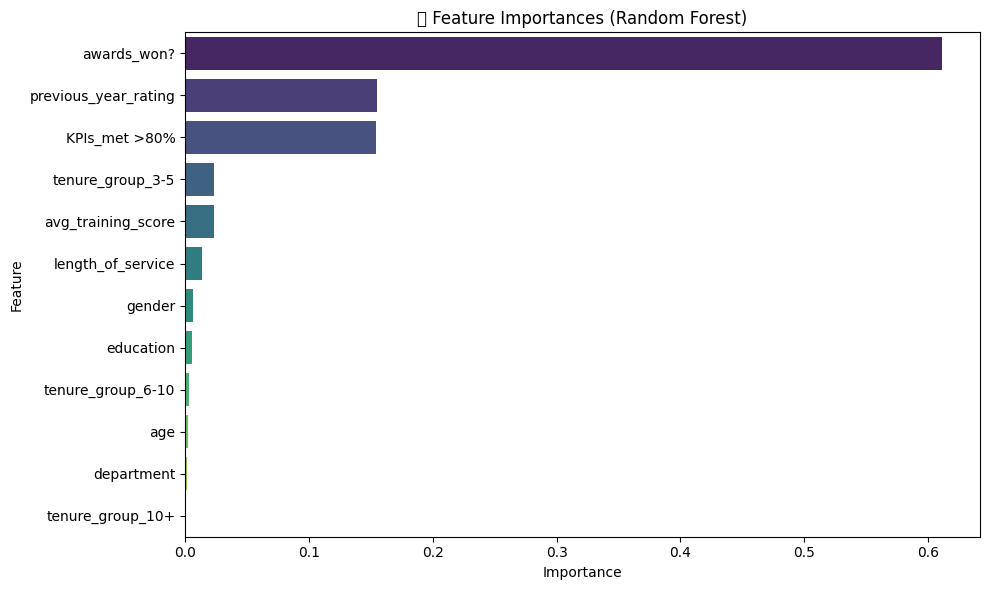

In [ ]:
importances = rf.feature_importances_
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
plt.title("📈 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [69]:
print("\n Random Forest:")
print(classification_report(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_pred))


 Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     10197
           1       0.93      0.95      0.94      9859

    accuracy                           0.94     20056
   macro avg       0.94      0.94      0.94     20056
weighted avg       0.94      0.94      0.94     20056

ROC AUC: 0.943385361129436


# XGBoost


In [70]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:
print("\nXGBoost Classifier:")
print(classification_report(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_pred))


XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     10197
           1       0.89      0.90      0.90      9859

    accuracy                           0.90     20056
   macro avg       0.90      0.90      0.90     20056
weighted avg       0.90      0.90      0.90     20056

ROC AUC: 0.8979913932670125


# DNN with Dropout


In [72]:
dl1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
dl1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [73]:
dl1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = dl1.fit(X_train_scaled, y_train, epochs=30, batch_size=64, validation_split=0.2,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=0)

In [74]:
dl1_pred = (dl1.predict(X_test_scaled) > 0.5).astype("int32")
print("\n DNN (Dropout):")
print(classification_report(y_test, dl1_pred))
print("ROC AUC:", roc_auc_score(y_test, dl1_pred))

627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

 DNN (Dropout):
              precision    recall  f1-score   support

           0       0.92      0.71      0.80     10197
           1       0.76      0.94      0.84      9859

    accuracy                           0.82     20056
   macro avg       0.84      0.82      0.82     20056
weighted avg       0.84      0.82      0.82     20056

ROC AUC: 0.8211908981660536


# DNN with BatchNorm


In [75]:
dl2 = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.3),
    Dense(64),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
dl2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)               

In [76]:
dl2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = dl2.fit(X_train_scaled, y_train, epochs=30, batch_size=64, validation_split=0.2,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=0)

In [77]:
dl2_pred = (dl2.predict(X_test_scaled) > 0.5).astype("int32")
print("\nDNN (BatchNorm):")
print(classification_report(y_test, dl2_pred))
print("ROC AUC:", roc_auc_score(y_test, dl2_pred))

627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

DNN (BatchNorm):
              precision    recall  f1-score   support

           0       0.89      0.75      0.82     10197
           1       0.78      0.90      0.84      9859

    accuracy                           0.83     20056
   macro avg       0.83      0.83      0.83     20056
weighted avg       0.84      0.83      0.83     20056

ROC AUC: 0.8284493718993959


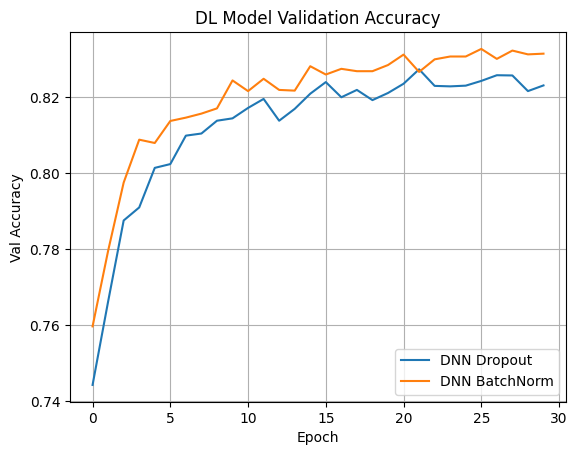

In [78]:
# Plot DL Accuracy Comparison
plt.plot(history1.history['val_accuracy'], label='DNN Dropout')
plt.plot(history2.history['val_accuracy'], label='DNN BatchNorm')
plt.title('DL Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
# Save All Models
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(xgb, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
dl1.save("dl_model_dropout.h5")
dl2.save("dl_model_batchnorm.h5")

print("\n All models saved.")


 All models saved.


In [80]:
# Step: Compare All Models
from sklearn.metrics import accuracy_score

# Gather accuracy and AUC
results = {
    "Random Forest": {
        "accuracy": accuracy_score(y_test, rf_pred),
        "roc_auc": roc_auc_score(y_test, rf_pred)
    },
    "XGBoost": {
        "accuracy": accuracy_score(y_test, xgb_pred),
        "roc_auc": roc_auc_score(y_test, xgb_pred)
    },
    "DNN Dropout": {
        "accuracy": accuracy_score(y_test, dl1_pred),
        "roc_auc": roc_auc_score(y_test, dl1_pred)
    },
    "DNN BatchNorm": {
        "accuracy": accuracy_score(y_test, dl2_pred),
        "roc_auc": roc_auc_score(y_test, dl2_pred)
    }
}

# Find the best model based on ROC AUC
best_model = max(results.items(), key=lambda x: x[1]['roc_auc'])

# Print Results
print("\n Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name:<20} | Accuracy: {metrics['accuracy']:.4f} | ROC AUC: {metrics['roc_auc']:.4f}")

print(f"\n Best Model Based on ROC AUC: {best_model[0]} with ROC AUC: {best_model[1]['roc_auc']:.4f}")



 Model Comparison:
Random Forest        | Accuracy: 0.9432 | ROC AUC: 0.9434
XGBoost              | Accuracy: 0.8979 | ROC AUC: 0.8980
DNN Dropout          | Accuracy: 0.8193 | ROC AUC: 0.8212
DNN BatchNorm        | Accuracy: 0.8272 | ROC AUC: 0.8284

 Best Model Based on ROC AUC: Random Forest with ROC AUC: 0.9434
